## Selección de keywords a partir de la aplicación de probability of words

In [1]:
#Se importan las librerías que serán utilizadas a lo largo de los análisis
from pymongo import MongoClient
import pandas as pd
import spacy
import re
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import numpy as np

Los datasets que contienen los tweets generados por los usuarios fueron guardadas en una base de datos no relacional denominada MongoDB. MongoDB almacena datos en documentos flexibles similares a JSON, con un formato denominado BSON. A continuación nos conectaremos con el servidor alojado en nuestra computadora particular y buscaremos los datasets y colecciones pertinentes

In [3]:
client = MongoClient('localhost', port=27017)

In [4]:
#para ver las bases que tengo en mongodb
print(client.list_database_names())

['admin', 'argentina', 'config', 'cordoba', 'keyword_obesidad', 'local', 'twitter_obesidad', 'twitter_obesidad_abril']


Primero se nombrarán los datasets que serán utilizados. Siguiendo la metodología propuesta para esta técnica definiremos como documento un dataset que contiene tweets relacionados con la temática de obesidad, el cual será denominado "data", y a posteriori, "data_obesidad". Este dataset fue construido durante el mes de mayo de 2021 con la utilización de palabras "semilla" como obesidad, obeso, obesa, obesos y obesas. Por otro lado tenemos un dataset de tweets recolectados durante junio el cual se denominará "nodata" y presenta sólo tweets de Argentina sin considerar palabras clave como filtro ni una temática en particular.

In [5]:
db = client.twitter_obesidad
print(db.collection_names)
collection = db.mayo

<bound method Database.collection_names of Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'twitter_obesidad')>


In [6]:
ndb = client.argentina
nocollection = ndb.junio

In [7]:
data = pd.DataFrame(list(collection.find()))
nodata = pd.DataFrame(list(nocollection.find()))

En el proximo comando definimos el dataset de las palabras semillas como "data_obesidad" dejando sólo 3 palabras semillas de las utilizadas (obesidad, obeso y obesa). A su vez se eliminarán todos lo tweets que fueron generados por usuarios con locación en países de habla hispana diferente a Argentina. Esto último también será aplicado sobre el "nodata" ya que si bien la recolección fue basada en coordenadas que delimitan el territorio argentino, a veces no suelen ser totalmente fiables o exactas y pueden incluir países aledaños.

In [8]:
data = data.drop(data[data['location'].str.lower().str.contains('peru|perú|bolivia|paraguay|uruguay|ecuador|mexico\
|colombia|venezuela|brasil|chile|españa|spain|mejico|costa rica|puerto rico|guatemala\
|nicaragua|panama|panamá|méxico|europa|brazil|barcelona|barranquilla|madrid|sevilla|valencia|málaga|bcn')==True].index)
data_obesidad = data[data['tweet'].str.lower().str.contains('obeso|obesa|obesidad')==True]
nodata = nodata.drop(nodata[nodata['location'].str.lower().str.contains('peru|perú|bolivia|paraguay|uruguay|ecuador|mexico\
|colombia|venezuela|brasil|chile|españa|spain|mejico|costa rica|puerto rico|guatemala\
|nicaragua|panama|panamá|méxico|europa|brazil|barcelona|barranquilla|madrid|sevilla|valencia|málaga|bcn')==True].index)

print('Tweets que forman el dataset incluyendo la palabra obeso, obesa y obesidad:',(data_obesidad.shape))
print('----------------------------')
print('Tweets que incluyen el no dataset, respetando que provienen sólo de Argentina:',(nodata.shape))
print('----------------------------')

Tweets que forman el dataset incluyendo la palabra obeso, obesa y obesidad: (7446, 10)
----------------------------
Tweets que incluyen el no dataset, respetando que provienen sólo de Argentina: (138571, 11)
----------------------------


In [9]:
#Se crea una nueva variable para clasificar los datasets por temática y no confundirlos una vez que se unan los mismos.
nodata['tema'] = 'argentina'
data_obesidad['tema'] = 'obesidad'

C:\Users\Eugenia\Miniconda3v1\envs\diplodatos\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Ahora se procederá a limpiar el texto de los tweets, para este proceso primero se eliminará el "ruido" de los mismos. Acto seguido se tokenizarán los tweets y obtendrá un nuevo texto.

In [10]:
def limpiar_tokenizar(texto):

    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    #Eliminación de los nombres de usuarios
    nuevo_texto = re.sub('@[A-Za-z0-9]+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub('\d+', ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub('\\s+', ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

print(limpiar_tokenizar(texto=str(data_obesidad['tweet'])))

['rt', 'esta', 'tarde', 'en', 'twitch', 'hablare', 'claro', 'claro', 'si', 'está', 'gorda', 'habrá', 'mi', 'la', 'obesidad', 'infantil', 'junto', 'al', 'sobrepeso', 'afec', 'quirónsalud', 'huelva', 'destaca', 'el', 'éxito', 'de', 'la', 'ci', 'owww', 'rt', 'los', 'obesos', 'conmebol', 'nos', 'man', 'es', 'que', 'esi', 'discurso', 'de', 'buaaaaa', 'obesidad', 'como', 'inmunización', 'para', 'personas', 'obesas', 'crear', 'desde', 'pequeños', 'hábitos', 'saludables', 'ayuda', 'name', 'tweet', 'length', 'dtype', 'object']


In [11]:
# Se aplica la función de limpieza y tokenización a cada tweet generando una nueva variable con el texto nuevo

data_obesidad['texto_tokenizado'] = data_obesidad['tweet'].apply(lambda x: limpiar_tokenizar(x))
nodata['texto_tokenizado'] = nodata['tweet'].apply(lambda x: limpiar_tokenizar(x))

C:\Users\Eugenia\Miniconda3v1\envs\diplodatos\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
# Se unen los dos dataframes en uno solo
tweets = pd.concat([nodata, data_obesidad], ignore_index=True)
tweets.shape

(146017, 13)

A continuación se aplica la función UNNEST, la cual devuelve una tabla de resultados que incluye una fila para cada elemento de la matriz especificada (token). Si se han especificado varios argumentos de matriz común, el número de filas coincidirá con la matriz que tenga la cardinalidad más alta.

In [13]:
# Unnest de la columna texto_tokenizado

tweets_tidy = tweets.explode(column='texto_tokenizado')
tweets_tidy = tweets_tidy.drop(columns='tweet')
tweets_tidy = tweets_tidy.rename(columns={'texto_tokenizado':'token'})
tweets_tidy.head()

,_id,user_id,username,location,coordinates,fecha_creacion,idioma,sentimiento,retweete,retweeted,tema,token
0,60c20f795261171ed30d5a6e,883073904159449088,Blacksmit 🌱,"Morteros, Córdoba",None,2021-06-10 13:11:13,es,,NaN,NaN,argentina,no
0,60c20f795261171ed30d5a6e,883073904159449088,Blacksmit 🌱,"Morteros, Córdoba",None,2021-06-10 13:11:13,es,,NaN,NaN,argentina,quiero
0,60c20f795261171ed30d5a6e,883073904159449088,Blacksmit 🌱,"Morteros, Córdoba",None,2021-06-10 13:11:13,es,,NaN,NaN,argentina,ni
0,60c20f795261171ed30d5a6e,883073904159449088,Blacksmit 🌱,"Morteros, Córdoba",None,2021-06-10 13:11:13,es,,NaN,NaN,argentina,saber
0,60c20f795261171ed30d5a6e,883073904159449088,Blacksmit 🌱,"Morteros, Córdoba",None,2021-06-10 13:11:13,es,,NaN,NaN,argentina,lo


In [14]:
# Palabras totales utilizadas por cada temática

print('--------------------------')
print('Palabras totales por tema')
print('--------------------------')
tweets_tidy.groupby(by='tema')['token'].count()

--------------------------
Palabras totales por tema
--------------------------


tema
argentina    1390706
obesidad      115502
Name: token, dtype: int64

In [15]:
# Palabras que son distintas utilizadas por cada temática

print('----------------------------')
print('Palabras distintas por tema')
print('----------------------------')
tweets_tidy.groupby(by='tema')['token'].nunique()

----------------------------
Palabras distintas por tema
----------------------------


tema
argentina    101956
obesidad      10845
Name: token, dtype: int64

En este método no es necesario eliminar las stopwords ya que las mismas debido a su alta frecuencia en ambos dataset quedarían con baja probabilidad. Sin embargo lo aplicaremos de todas formas, adhiriendo las palabras semillas a las stopwords, las cuales están contenidas en los tweets del dataset 'data_obesidad' y no serviría que sean arrojadas como posibles resultados.

In [16]:
# Obtención de listado de stopwords del español

from nltk.corpus import stopwords
stop_words = list(stopwords.words('spanish'))
# Se añade la stoprword: rt al igual que las palabras semilla
stop_words.extend(('rt','obeso','obesa', 'obesidad', 'si', 'así', 'ángu…'))

In [17]:
# Se realiza un filtrado para excluir stopwords

tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]

A continuación se realizará un "pivotado". El mismo consiste en crear nuevas columnas que sustituyen a las columnas originales que fueron seleccionadas para crear la tabla dinámica.

In [18]:
# Pivotado de datos

tweets_pivot = tweets_tidy.groupby(["tema","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="tema", values= "count")
tweets_pivot.columns.name = None

En el próximo comando realizamos un test de correlación (teniendo en cuenta la similitud coseno) para conocer que tan correlacionadas se encuentran los dataset según el uso y frecuencia de las palabras. Mientras más bajo sea el valor, menos relación entre los términos presentan los datasets.

In [19]:
# Test de correlación (coseno) por el uso y frecuencia de palabras

from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

tweets_pivot.corr(method=similitud_coseno)

,argentina,obesidad
argentina,1.000000,0.428428
obesidad,0.428428,1.000000


C:\Users\Eugenia\Miniconda3v1\envs\diplodatos\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128071 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Eugenia\Miniconda3v1\envs\diplodatos\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 127995 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Eugenia\Miniconda3v1\envs\diplodatos\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 129316 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Eugenia\Miniconda3v1\envs\diplodatos\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 129318 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Eugenia\Miniconda3v1\envs\diplodatos\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128071 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Eugenia\

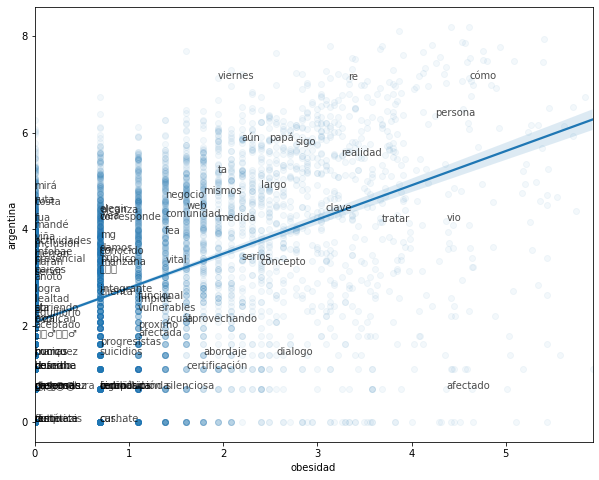

In [20]:
# Gráfico de correlación

f, ax = plt.subplots(figsize=(10, 8))
temp = tweets_pivot.dropna()
sns.regplot(
    x  = np.log(temp.obesidad),
    y  = np.log(temp.argentina),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        text  = temp.index[i],
        xy    = (np.log(temp.obesidad[i]), np.log(temp.argentina[i])),
        alpha = 0.7
    )

En el gráfico de correlación se presenta en el eje x la temática "obesidad" y en el eje y el dataset de Argentina.

In [21]:
# Número de palabras comunes

palabras_argentina = set(tweets_tidy[tweets_tidy.tema == 'argentina']['token'])
palabras_obesidad = set(tweets_tidy[tweets_tidy.tema == 'obesidad']['token'])

print(f"Palabras comunes entre dataset de argentina y de obesidad: {len(palabras_argentina.intersection(palabras_obesidad))}")

Palabras comunes entre dataset de argentina y de obesidad: 7650


In [22]:
# Cálculo del log of odds ratio de cada palabra (argentina vs obesidad)


# Pivotaje y despivotaje
tweets_pivot = tweets_tidy.groupby(["tema","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="tema", values= "count")

tweets_pivot = tweets_pivot.fillna(value=0)
tweets_pivot.columns.name = None

tweets_unpivot = tweets_pivot.melt(value_name='n', var_name='tema', ignore_index=False)
tweets_unpivot = tweets_unpivot.reset_index()
tweets_unpivot = tweets_unpivot[tweets_unpivot.tema.isin(['argentina', 'obesidad'])]

# Se añade el total de palabras de cada temática
tweets_unpivot = tweets_unpivot.merge(
                    tweets_tidy.groupby('tema')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'tema'
                 )

# Cálculo de odds y log of odds de cada palabra
tweets_logOdds = tweets_unpivot.copy()
tweets_logOdds['odds'] = (tweets_logOdds.n + 1) / (tweets_logOdds.N + 1)
tweets_logOdds = tweets_logOdds[['token', 'tema', 'odds']] \
                    .pivot(index='token', columns='tema', values='odds')
tweets_logOdds.columns.name = None

tweets_logOdds['log_odds']     = np.log(tweets_logOdds.argentina/tweets_logOdds.obesidad)
tweets_logOdds['abs_log_odds'] = np.abs(tweets_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de aparecer en el nodata. Esto es así porque el ratio sea ha
# calculado como argentina/obesidad.
tweets_logOdds['tema_frecuente'] = np.where(tweets_logOdds.log_odds > 0,
                                              "argentina",
                                              "obesidad"
                                    )

In [23]:
print('-----------------------------------')
print('Top 10 palabras más diferenciadoras')
print('-----------------------------------')
tweets_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

-----------------------------------
Top 10 palabras más diferenciadoras
-----------------------------------


,argentina,obesidad,log_odds,abs_log_odds,tema_frecuente
token,,,,,
obesos,0.000001,0.007407,-8.688434,8.688434,obesidad
picame,0.000001,0.004161,-8.111724,8.111724,obesidad
mórbida,0.000001,0.003945,-8.058614,8.058614,obesidad
probiótico,0.000001,0.002923,-7.758737,7.758737,obesidad
seagal,0.000001,0.002852,-7.733891,7.733891,obesidad
adelgace,0.000001,0.002744,-7.695424,7.695424,obesidad
alcohóli…,0.000001,0.002726,-7.688867,7.688867,obesidad
obesas,0.000001,0.002313,-7.524799,7.524799,obesidad
csic,0.000001,0.002134,-7.444110,7.444110,obesidad


Para observar estas palabras de una manera más ilustrativa se presenta el siguiente gráfico

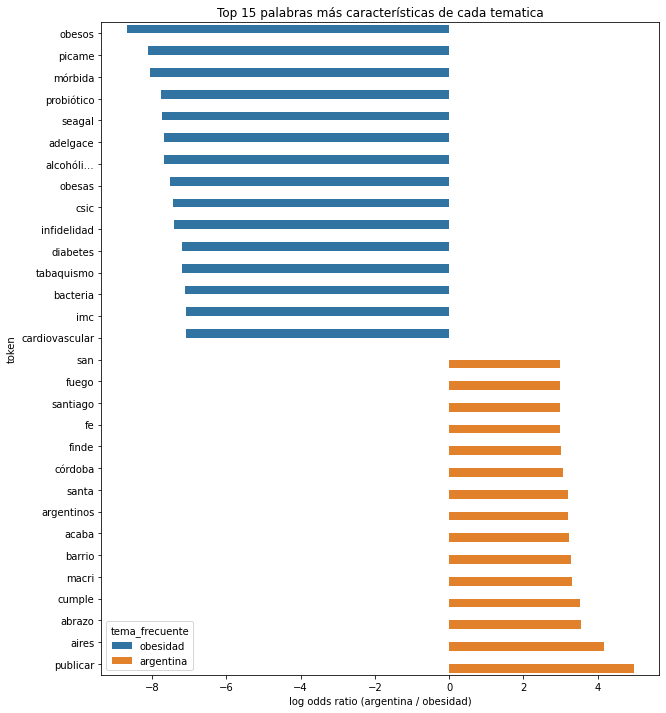

In [24]:
# Top 15 palabras más características de cada temática


top_30 = tweets_logOdds[['log_odds', 'abs_log_odds', 'tema_frecuente']] \
        .groupby('tema_frecuente') \
        .apply(lambda x: x.nlargest(15, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(10, 12))
sns.barplot(
    x    = 'log_odds',
    y    = 'token',
    hue  = 'tema_frecuente',
    data = top_30,
    ax   = ax
)


ax.set_title('Top 15 palabras más características de cada tematica')
ax.set_xlabel('log odds ratio (argentina / obesidad)');

### ACA CONCLUSIÓN 